PART A: Grab the Data

In [2]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [ ]:
df_train.head(50)

PART B: Explore the Data

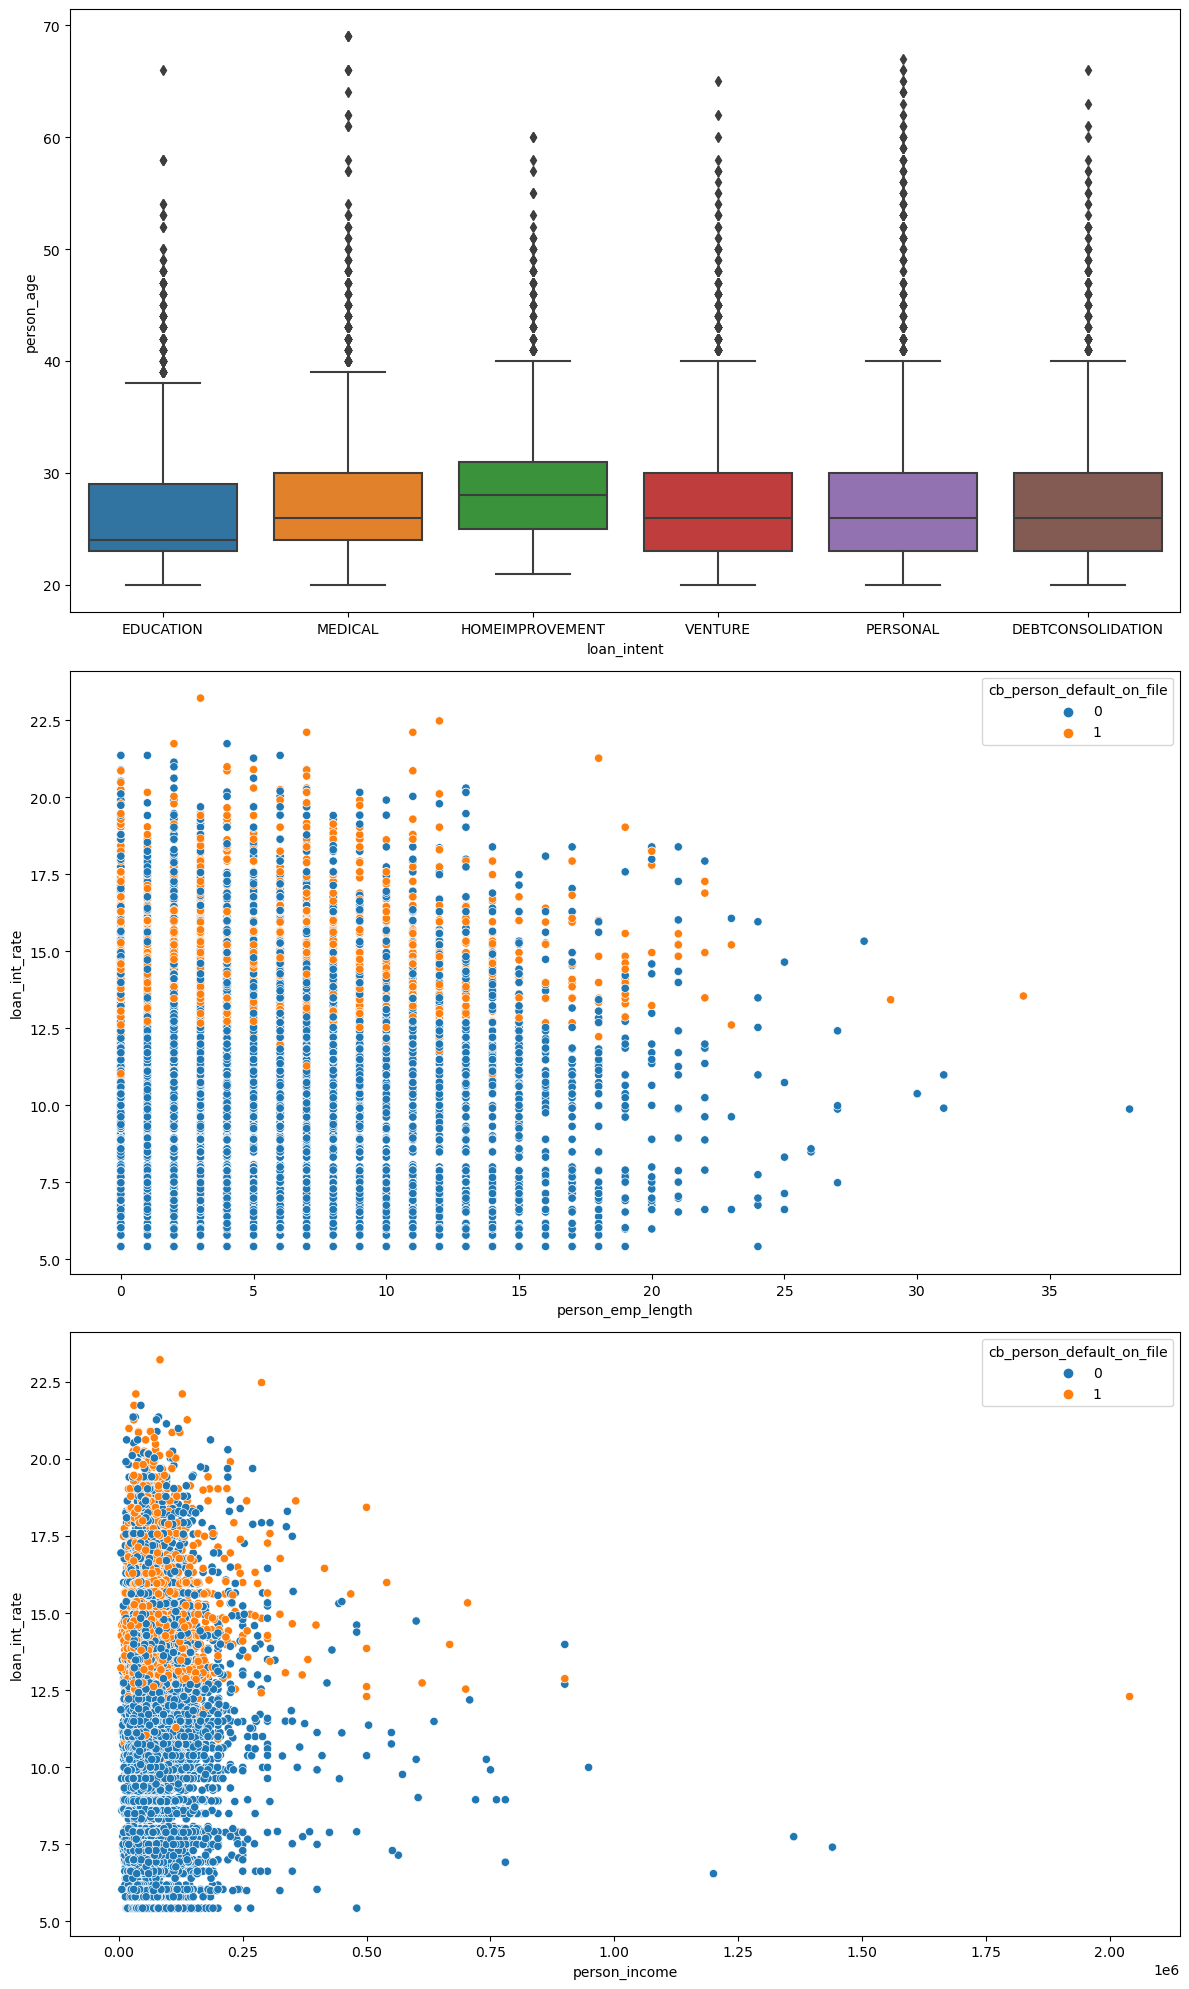

In [9]:
# SUMMARY TABLE

#summary_table = df_train.groupby('loan_intent')['loan_int_rate'].agg(['mean', 'median']).reset_index()
#summary_table.columns = ['Loan Intent', 'Mean Loan Interest Rate', 'Median Loan Interest Rate']

#summary_table2 = df_train.groupby('person_home_ownership')['cb_person_cred_hist_length'].agg(['mean']).reset_index()
#summary_table2.columns = ['Person Home Ownership', "Mean Credit History Length"]

#print(summary_table)
#print(summary_table2)

import matplotlib.pyplot as plt
import seaborn as sns

# TWO DATA VISUALIZATIONS

#avg_age_by_intent = df_train.groupby("loan_intent")['person_age'].mean().reset_index()
#avg_employment_length_by_intent = df_train.groupby("loan_intent")['person_emp_length'].mean().reset_index()
#home_ownership = df_train.groupby("person_home_ownership")['loan_int_rate'].mean().reset_index()

plt.figure(figsize=(12, 20))

# Modify dataset to remove datapoints with person_age > 90 and person_employment_length > 40
df_train = df_train[df_train['person_age'] < 70]
df_train = df_train[df_train['person_emp_length'] < 40]

plt.subplot(3, 1, 1)

smaller_df = df_train.head(200)
sns.boxplot(x= "loan_intent", y= "person_age", data= df_train)

plt.subplot(3, 1, 2)
sns.scatterplot(x= 'person_emp_length', y= 'loan_int_rate', hue= 'cb_person_default_on_file', data= df_train)

plt.subplot(3, 1, 3)
sns.scatterplot(x= 'person_income', y= 'loan_int_rate', hue= 'cb_person_default_on_file', data= df_train)
#sns.barplot(x= "person_home_ownership", )

plt.tight_layout()
plt.show()


In [85]:
df_train['cb_person_default_on_file'] = df_train['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})

# Code comes from: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
import numpy as np

# Import Linear Regression packages
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter = 1000) 

df_train.dropna(inplace=True)

X = df_train.drop(['loan_intent', 'person_home_ownership', 'loan_grade', 'loan_status'], axis = 1)

y = df_train['loan_status']

PART C: Build a Model

In [86]:
# Sequential Feature Selector (Cross-validation is built into this model)

sfs_forward = SequentialFeatureSelector(
    LR, n_features_to_select=3, direction="forward"
).fit(X, y)


sfs_backward = SequentialFeatureSelector(
    LR, n_features_to_select=3, direction="backward"
).fit(X, y)


print(
    "Features selected by forward sequential selection: "
    f"{X.columns[sfs_forward.get_support()]}"
)

print(
    "Features selected by backward sequential selection: "
    f"{X.columns[sfs_backward.get_support()]}"
)

fcols = X.columns[sfs_forward.get_support()]
bcols = X.columns[sfs_backward.get_support()]

X_train = df_train[fcols]
y_train = df_train["loan_status"]

X_train

Features selected by forward sequential selection: Index(['person_emp_length', 'loan_int_rate', 'loan_percent_income'], dtype='object')
Features selected by backward sequential selection: Index(['person_income', 'loan_amnt', 'cb_person_cred_hist_length'], dtype='object')


,person_emp_length,loan_int_rate,loan_percent_income
1,3.0,13.47,0.12
2,5.0,7.51,0.27
3,2.0,12.87,0.05
4,2.0,9.63,0.28
6,2.0,14.91,0.25
...,...,...,...
26059,8.0,7.29,0.02
26060,1.0,5.42,0.09
26061,0.0,11.71,0.25
26062,12.0,12.68,0.24


In [105]:
# X_train are feature columns (use a new dataframe with just those columns)

# Fitting the Logistic Regression
LR.fit(X_train, y_train)

coef = LR.coef_

# LR.predict_proba(X_train) is equivalent to X_train@LR.coef_ via SciKitLearn / TA Bell
probs = LR.predict_proba(X_train)

# Take the 0th index of each prob element which is the probability of a 0, via array slicing
# This is the probability that the person did NOT default on their loan
no_default_prob = probs[:, 0]

In [106]:
coef

array([[-0.04430865,  0.28906601,  8.38643566]])

In [88]:
probs

# 0 = DID NOT DEFAULT
# 1 = DEFAULTED

# probability that the person did not default

array([[0.79520771, 0.20479229],
       [0.87102954, 0.12897046],
       [0.8882301 , 0.1117699 ],
       ...,
       [0.65525076, 0.34474924],
       [0.72658701, 0.27341299],
       [0.77187128, 0.22812872]])

In [93]:
threshold = 0.4
newDF = df_train[no_default_prob > threshold]
sortedDF = newDF.sort_values(by=['loan_status'])
sortedDF
#newDF['']

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,1,6
16546,24,45000,RENT,1.0,PERSONAL,C,2000,13.99,0,0.04,1,2
16544,31,96000,MORTGAGE,15.0,HOMEIMPROVEMENT,D,8000,14.09,0,0.08,1,9
16543,22,35064,RENT,4.0,DEBTCONSOLIDATION,A,2000,8.38,0,0.06,0,2
16542,28,62000,RENT,0.0,HOMEIMPROVEMENT,A,15000,7.90,0,0.24,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
21176,26,44000,RENT,5.0,DEBTCONSOLIDATION,C,4600,13.99,1,0.10,0,4
3989,26,34000,RENT,2.0,MEDICAL,B,13000,9.63,1,0.38,0,2
9029,25,39000,RENT,2.0,VENTURE,C,8500,13.23,1,0.22,1,4
9028,34,54000,RENT,5.0,MEDICAL,D,3000,15.37,1,0.06,1,6


In [100]:
#def calc_profit(default_prob, threshold, loan_amnts, loan_int_rate, y_train):
y_train

1        0
2        0
3        1
4        0
6        1
        ..
26059    0
26060    0
26061    0
26062    0
26063    1
Name: loan_status, Length: 22892, dtype: int64

In [111]:
total_profits = []

# Iterating through threshold values
thresholds = np.linspace(0.01, 1, 100)

max_profit = 0
optimal_threshold = 0

for threshold in thresholds:

    # Defaults are the items with predict_proba of 0 is greater than the threshold, repayments have predict_proba for 0 that are less than threshold

    # These are all the people expected to pack back their loans
    People_given_loans = df_train[no_default_prob > threshold]
    
    # Extract the loan amount/interest rate from each item categorized as a default
    loan_amnt = People_given_loans['loan_amnt']
    loan_int_rate = People_given_loans['loan_int_rate']

    y = People_given_loans['loan_status']

    # Profit formula if borrower defaults on loan
    default_profit_formula = loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt
    default_profit = default_profit_formula * (y) 

    # Profit formula if borrower repays loan
    repayment_profit_formula = loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt
    repayment_profit = repayment_profit_formula * (1 - y)

    total_profit_per_person = repayment_profit - default_profit
    total_profit = total_profit_per_person.sum()
    total_profits.append(total_profit)

    if total_profit > max_profit:
        max_profit = total_profit
        optimal_threshold = threshold

    








#print("The LR.coef is: ", LR.coef_)
#print("Probs: ", probs)

# Cross validate, use best scoring as parameters to grid CV
# Retrieve weight vector, stored as an attribute
# Predict.proba

PART D: Find a Threshold

<Axes: >

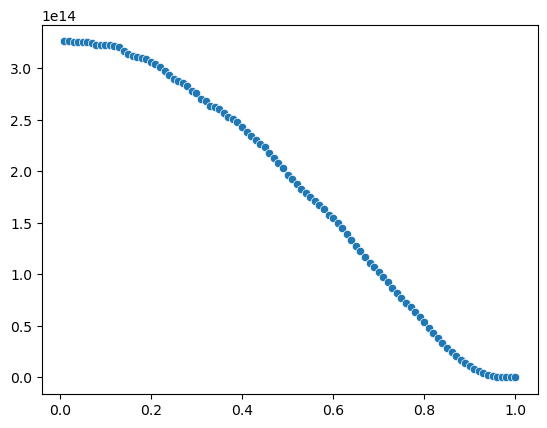

In [112]:
import seaborn as sns

sns.scatterplot(x= thresholds, y= total_profits)

EVALUATE MODEL FROM BANK'S PERSPECTIVE

Error rate vs profit

In [ ]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)